In [1]:
from copy import copy
import random
import numpy as np
import matplotlib.pyplot as plt
import math

## Some useful constants

In [2]:
NORTH_PROB = 0.75

## Define the env

In [3]:
class TrafficLightEnv():
    def __init__(self, car_arrival_prob=0.75, max_queue_size=10):
        self.car_arrival_prob = car_arrival_prob
        self.max_queue_size = max_queue_size
        
    def reset(self):
        return [0, 0, 'N']
        
    def step(self, state, action):
            old_state = copy(state)
            q_0, q_1, direction = state
            new_state = (q_0, q_1, direction)
        
            # Handle car departures based on the current direction
            if direction == 'N' and action == 'No-Op':
                departed_cars = min(q_0, 2)
                q_0 = max(q_0 - departed_cars, 0)
            elif direction == 'E' and action == 'No-Op':
                departed_cars = min(q_1, 2)
                q_1 = max(q_1 -departed_cars, 0)
            
            # Switch direction if action is to switch
            if action == 'Switch':
                direction = 'E' if direction == 'N' else 'N'
                
            # compute the rewards before cars arrive
            new_state = (q_0, q_1, direction)
            reward = self.reward(old_state, new_state)
            
            # Handle car arrivals probabilistically
            if random.random() < self.car_arrival_prob:
                if q_0 < self.max_queue_size: q_0 += 1
            else:
                if q_1 < self.max_queue_size: q_1 += 1
            
            # Update state after cars arrive
            new_state = (q_0, q_1, direction)
        
            return new_state, reward
        
    def reward(self, curr_state, next_state):
        """The reward is +1 for each departed car, -1 for each queue greater than 5"""
        north_reward = max(curr_state[0] - next_state[0], 0)
        east_reward = max(curr_state[1] - next_state[1], 0)
        north_penalty = -1 if next_state[0] > 5 else 0
        east_penalty = -1 if next_state[1] > 5 else 0
        return north_reward + east_reward + north_penalty + east_penalty
        
        

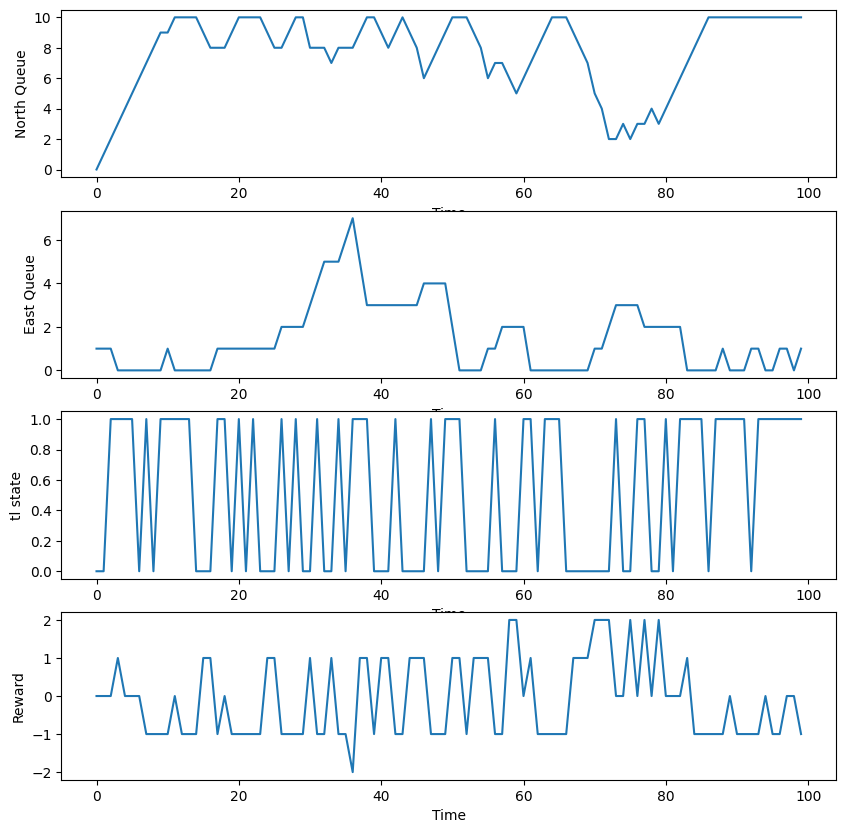

In [4]:
# Lets do a random rollout and visualize the length of each of the queues and the reward
# as a function of time
# set a seed so that the problem is reproducible
np.random.seed(0)
math.random.seed(0)
episode_length = 100
max_queue_size = 10
env = TrafficLightEnv(car_arrival_prob=NORTH_PROB, max_queue_size=max_queue_size)
state = env.reset()
states = np.zeros((episode_length, 2))
tl_state = np.zeros(episode_length)
rewards = np.zeros(episode_length)
for t in range(episode_length):
    action = random.choice(['No-Op', 'Switch'])
    state, reward = env.step(state, action)
    states[t, 0] = state[0]
    states[t, 1] = state[1]
    tl_state[t] = 1 if state[2] == 'E' else 0
    rewards[t] = reward
    
# plot the queues on one plot and then the rewards on another
# in a grid
fig, ax = plt.subplots(4, 1, figsize=(10, 10))
ax[0].plot(states[:, 0])
ax[0].set_xlabel('Time')
ax[0].set_ylabel('North Queue')

ax[1].plot(states[:, 1])
ax[1].set_xlabel('Time')
ax[1].set_ylabel('East Queue')
# ax[0].legend(['Queue 0', 'Queue 1'])

ax[2].plot(tl_state)
ax[2].set_xlabel('Time')
ax[2].set_ylabel('tl state')

ax[3].plot(rewards)
ax[3].set_xlabel('Time')
ax[3].set_ylabel('Reward')
plt.show()


## I'm too lazy to write out the transition functions, so lets compute them by sampling

In [5]:
# the elements of the transition matrix are the probabilities of transitioning from one state to another
# the transition matrix is a 7-dimensional array, with the first 3 dimensions representing the current state
# the fourth dimension representing the action
# and the last 3 dimensions representing the next state
transition_probs = np.zeros((max_queue_size + 1, 
                             max_queue_size + 1, 
                             2, 
                             2,
                             max_queue_size + 1,
                             max_queue_size + 1, 
                             2))
num_rollouts = 500
env = TrafficLightEnv(car_arrival_prob=NORTH_PROB)
for i in range(num_rollouts):
    state = env.reset()
    for t in range(100):
        action = random.choice(['No-Op', 'Switch'])
        new_state, reward = env.step(state, action)
        transition_probs[state[0], state[1], 0 if state[2] == 'N' else 1, 
                         0 if action == 'No-Op' else 1, 
                         new_state[0], new_state[1], 0 if new_state[2] == 'N' else 1] += 1
        state = new_state
# now we need to normalize the transition probabilities
# normally we would vectorize this but it's clearer to write it out
for q_0 in range(11):
    for q_1 in range(11):
        for direction in range(2):
            for action in range(2):
                if transition_probs[q_0, q_1, direction, action].sum() > 0:
                    transition_probs[q_0, q_1, direction, action] /= transition_probs[q_0, q_1, direction, action].sum()

## Lets look at an example transition probability

In [6]:
# this is no cars in either direction, Green facing north
# we ask for the action to switch and then ask what is the 
# probability that the next state will be 0, 1, 'E'
# it should be around 0.25!
transition_probs[0, 0, 0, 1, 0, 1, 1]

0.225

## Now lets compute the value and policy by value iteration

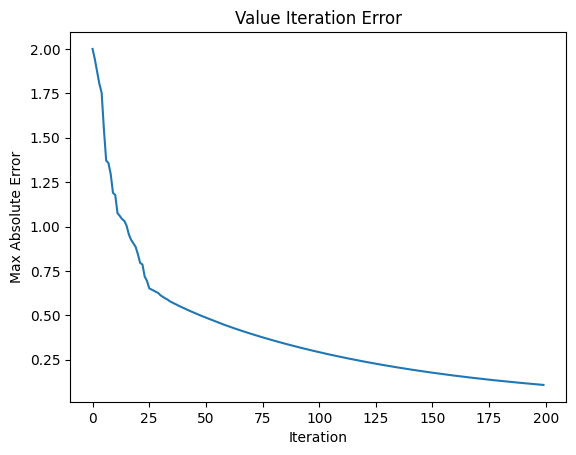

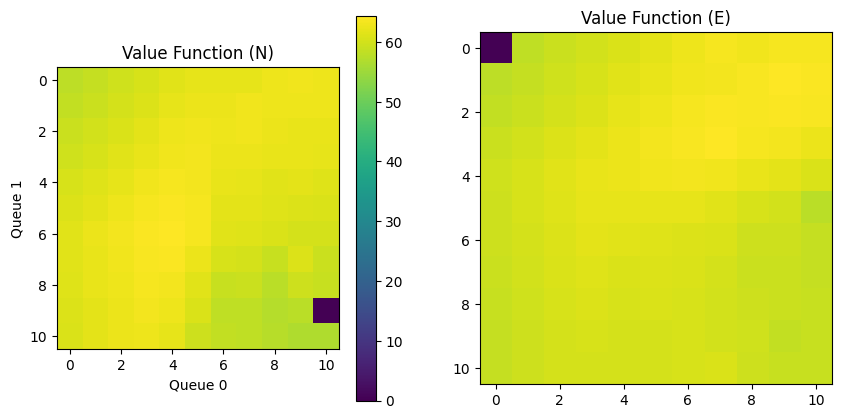

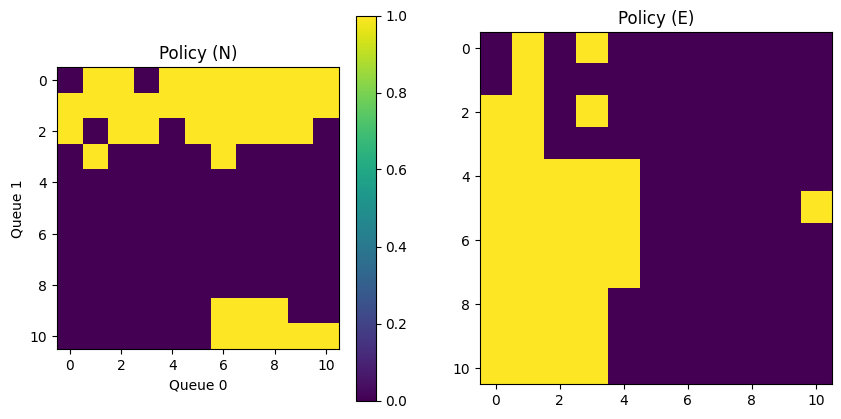

In [7]:
# okay, now we can run value iteration 
discount = 0.99
epsilon = 0.001
value = np.zeros((max_queue_size + 1, max_queue_size + 1, 2))
policy = np.zeros((max_queue_size + 1, max_queue_size + 1, 2))
observed_error = []
for i in range(200):
    new_value = np.zeros((max_queue_size + 1, max_queue_size + 1, 2))
    for x in range(max_queue_size + 1):
        for y in range(max_queue_size + 1):
            for curr_direction in range(2):
                best_action = 0
                best_value = -np.inf
                for a in range(2):
                    action_value = 0 # Corrected variable name
                    for next_x in range(max_queue_size + 1):
                        for next_y in range(max_queue_size + 1):
                            for next_direction in range(2):
                                action_value += transition_probs[x, y, curr_direction, a, next_x, next_y, next_direction] * \
                                  (env.reward((x, y, curr_direction), (next_x, next_y, next_direction)) \
                                    + discount * value[next_x, next_y, next_direction]) # Use value for discounted future values
                    if action_value > best_value:
                        best_value = action_value
                        best_action = a
                new_value[x, y, curr_direction] = best_value
                policy[x, y, curr_direction] = best_action
    if np.abs(new_value - value).max() < epsilon:
        break
    else:
        observed_error.append(np.abs(new_value - value).max())
    value = new_value # Correctly update value array after each iteration

# plot the error over time
plt.figure()
plt.plot(observed_error)
plt.title('Value Iteration Error')
plt.xlabel('Iteration')
plt.ylabel('Max Absolute Error')
plt.show()

# Lets also plot the value function as a heatmap for each direction
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(value[:, :, 0])
ax[0].set_title('Value Function (N)')
ax[1].imshow(value[:, :, 1])
ax[1].set_title('Value Function (E)')
# add some x and y labels
ax[0].set_xlabel('Queue 0')
ax[0].set_ylabel('Queue 1')
# add a vertical plot indicating what the colors mean
plt.colorbar(ax[0].imshow(value[:, :, 0]), ax=ax[0])
plt.show()

# Finally lets plot the policy at each state
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(policy[:, :, 0])
ax[0].set_title('Policy (N)')
ax[1].imshow(policy[:, :, 1])
ax[1].set_title('Policy (E)')
# add some x and y labels
ax[0].set_xlabel('Queue 0')
ax[0].set_ylabel('Queue 1')
# add a vertical plot indicating what the colors mean
plt.colorbar(ax[0].imshow(policy[:, :, 0]), ax=ax[0])
plt.show()

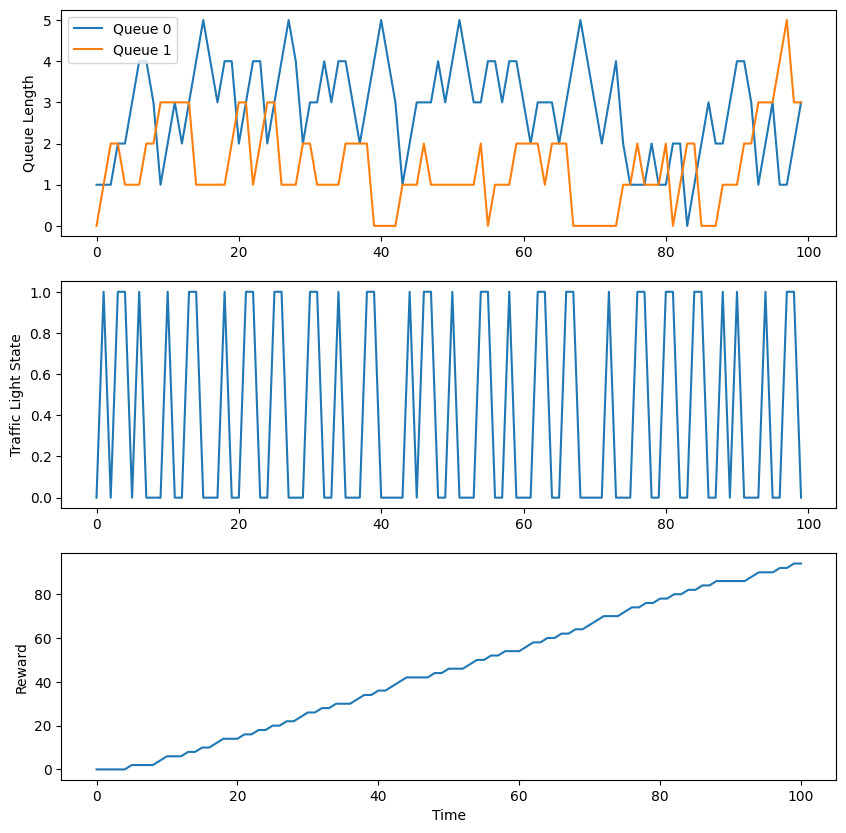

In [8]:
# okay now lets run the policy and see how it goes!
# Lets do a rollout and visualize the length of each of the queues and the reward
# as a function of time
episode_length = 100
max_queue_size = 10
env = TrafficLightEnv(car_arrival_prob=NORTH_PROB, max_queue_size=max_queue_size)
state = env.reset()
states = np.zeros((episode_length, 3))
rewards = np.zeros(episode_length + 1)
    
for t in range(episode_length):
    action = ['No-Op', 'Switch'][int(policy[state[0], state[1], 0 if state[2] == 'N' else 1])]
    new_state, reward = env.step(state, action)
    states[t, 0] = new_state[0]
    states[t, 1] = new_state[1]
    states[t, 2] = 1 if new_state[2] == 'E' else 0
    rewards[t + 1] = reward + rewards[t]
    state = new_state
    
# plot the queues on one plot and then the rewards on another
# in a grid
fig, ax = plt.subplots(3, 1, figsize=(10, 10))
ax[0].plot(states[:, :2])
ax[0].set_ylabel('Queue Length')
ax[0].legend(['Queue 0', 'Queue 1'])

# plot the tl states
ax[1].plot(states[:, 2])
ax[1].set_ylabel('Traffic Light State')

ax[2].plot(rewards)
ax[2].set_xlabel('Time')
ax[2].set_ylabel('Reward')
plt.show()

In [9]:
# how often does the traffic light face east
states[:, 2].sum() / len(states[:, 2])

0.41

## Now lets do this for Q-learning

In [73]:
# okay, now we can run q function iteration 
discount = 0.99
epsilon_greedy = 0.1
episode_length = 100
learning_rate = lambda x: 0.1 #0.1 / x
num_rollouts = 10000
q_function = np.random.uniform(low=-50, high=50, size=(max_queue_size + 1, max_queue_size + 1, 2, 2))
def sampling_strategy(q_function, epsilon_greedy):
    if random.random() < epsilon_greedy:
        return random.choice([0, 1])
    else:
        return np.argmax(q_function)
    
# TODO(ev) this is not great, don't do string renaming like this
def state_to_arr(state):
    return np.array([state[0], state[1], 0 if state[2] == 'N' else 1])
    
# run some number of iterations of q-learning
for i in range(1, num_rollouts):
    num_steps = 0
    state = state_to_arr(env.reset())
    while num_steps < episode_length:
        action = sampling_strategy(q_function[state[0], state[1], state[2], :], epsilon_greedy)
        next_state, reward = env.step(state, ['No-Op', 'Switch'][action])
        next_state = state_to_arr(next_state)
        q_function[state[0], state[1], state[2], action] += \
            learning_rate(i) * (reward + discount * np.max(q_function[next_state[0], next_state[1], next_state[2], :]) \
                - q_function[state[0], state[1], state[2], action])
        state = next_state
        num_steps += 1

    

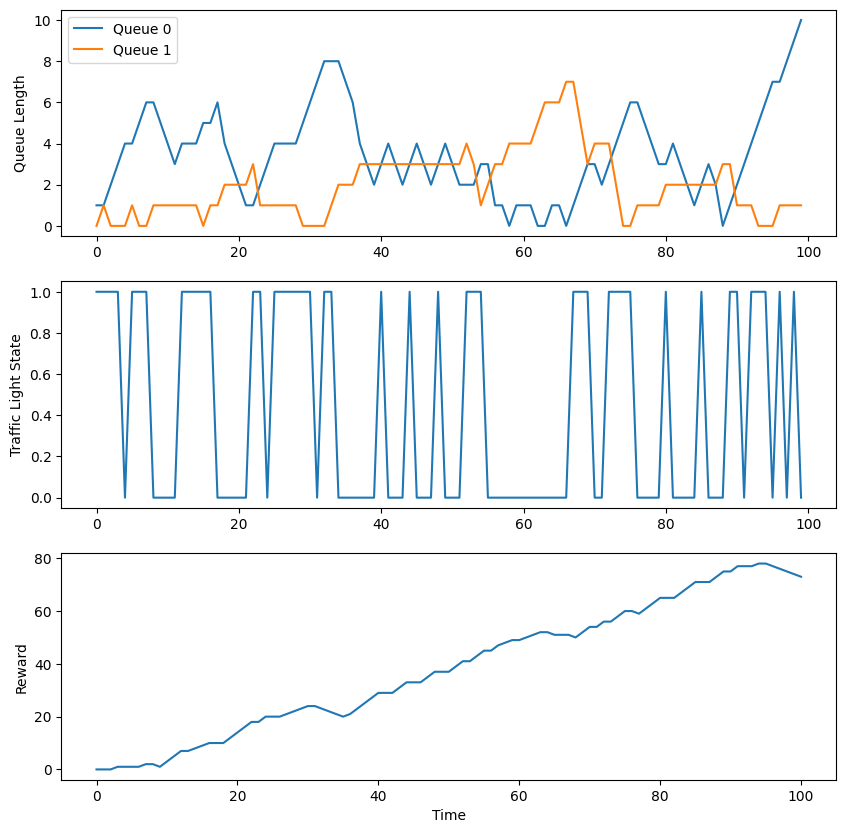

In [74]:
# now lets use the policy to actually do some control
# okay now lets run the policy and see how it goes!
# Lets do a rollout and visualize the length of each of the queues and the reward
# as a function of time
episode_length = 100
max_queue_size = 10
env = TrafficLightEnv(car_arrival_prob=NORTH_PROB, max_queue_size=max_queue_size)
state = env.reset()
states = np.zeros((episode_length, 3))
rewards = np.zeros(episode_length + 1)
    
for t in range(episode_length):
    action = ['No-Op', 'Switch'][np.argmax(q_function[state[0], state[1], 0 if state[2] == 'N' else 1])]
    new_state, reward = env.step(state, action)
    states[t, 0] = new_state[0]
    states[t, 1] = new_state[1]
    states[t, 2] = 1 if new_state[2] == 'E' else 0
    rewards[t + 1] = reward + rewards[t]
    state = new_state
    
# plot the queues on one plot and then the rewards on another
# in a grid
fig, ax = plt.subplots(3, 1, figsize=(10, 10))
ax[0].plot(states[:, :2])
ax[0].set_ylabel('Queue Length')
ax[0].legend(['Queue 0', 'Queue 1'])

# plot the tl states
ax[1].plot(states[:, 2])
ax[1].set_ylabel('Traffic Light State')

ax[2].plot(rewards)
ax[2].set_xlabel('Time')
ax[2].set_ylabel('Reward')
plt.show()

In [12]:
q_function

array([[[[-1.62832557e+02, -1.63142808e+02],
         [ 4.05289850e+01, -9.02324747e+00]],

        [[-1.46660031e+02, -1.54806059e+02],
         [-1.53805669e+02, -1.54884564e+02]],

        [[-1.24273503e+02, -1.25196919e+02],
         [-1.19090583e+02, -1.33575614e+02]],

        [[-7.37770400e+01, -7.64251400e+01],
         [-6.06631158e+01, -5.45566326e+01]],

        [[-1.53772025e+01, -1.30625604e+01],
         [-2.12345722e+01, -1.89754386e+01]],

        [[ 2.76525899e+01,  3.29061040e+01],
         [-2.29906795e+01, -3.91035770e+01]],

        [[ 2.94336528e+01,  1.89300832e+01],
         [ 2.91411055e+00, -4.14981534e+01]],

        [[ 2.86383353e+01,  1.24630589e+01],
         [-2.77831387e+01,  1.70173295e+00]],

        [[ 1.77145794e+01, -3.86301460e+01],
         [ 1.48898491e+01,  4.42896479e+00]],

        [[-1.55529758e+01, -9.23387176e+00],
         [-4.86104691e+01, -7.94740274e+00]],

        [[ 4.21792882e+01,  2.66302746e+01],
         [-4.70954177e+01, -5.82632

## Now lets do the function approximation version of Q-learning

In [65]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.distributions import Categorical

class QFunction(nn.Module):
    def __init__(self, state_space=3, action_space=2):
        super(QFunction, self).__init__()
        self.fc1 = nn.Linear(state_space, 128)
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, action_space)
        
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return F.softmax(x, dim=0)
    
class ReplayBuffer():
    def __init__(self, buffer_size=1000):
        self.buffer_size = buffer_size
        self.buffer = []
        
    def add(self, state, action, reward, next_state):
        if len(self.buffer) > self.buffer_size:
            self.buffer.pop(0)
        self.buffer.append((state, action, reward, next_state))
        
    def sample(self, batch_size=32):
        return random.sample(self.buffer, batch_size)
    
    def __len__(self):
        return len(self.buffer)
    
class DQN():
    def __init__(self, state_space=3, action_space=2, buffer_size=1000, batch_size=32, gamma=0.99, lr=3e-4):
        self.q_function = QFunction(state_space, action_space)
        self.optimizer = optim.Adam(self.q_function.parameters(), lr=lr)
        self.buffer = ReplayBuffer(buffer_size)
        self.batch_size = batch_size
        self.gamma = gamma
        
    def act(self, state, epsilon_greedy=0.1, random_action=True):
        if random.random() < epsilon_greedy and random_action:
            return random.choice([0, 1])
        else:
            return torch.argmax(self.q_function(torch.tensor(state, dtype=torch.float32))).item()
        
    def learn(self):
        if len(self.buffer) < self.batch_size:
            return
        batch = self.buffer.sample(self.batch_size)
        state, action, reward, next_state = zip(*batch)
        state = torch.tensor(state, dtype=torch.float32)
        action = torch.tensor(action, dtype=torch.int64)
        reward = torch.tensor(reward, dtype=torch.float32)
        next_state = torch.tensor(next_state, dtype=torch.float32)
        q_values = self.q_function(state)
        next_q_values = self.q_function(next_state)
        target_q_values = reward + self.gamma * torch.max(next_q_values, dim=1)[0]
        loss = F.mse_loss(q_values.gather(1, action.view(-1, 1)), target_q_values.view(-1, 1))
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        return loss.item()
    
    def add(self, state, action, reward, next_state):
        self.buffer.add(state, action, reward, next_state)
        
    def __len__(self):
        return len(self.buffer)

In [68]:
# okay, now we can run q function iteration 
discount = 0.99
epsilon_greedy = 0.1
episode_length = 100
num_rollouts = 5000
q_function = DQN(state_space=3, action_space=2, gamma=discount, batch_size=256)
    
# TODO(ev) this is not great, don't do string renaming like this
def state_to_arr(state):
    return np.array([state[0], state[1], 0 if state[2] == 'N' else 1])
    
# run some number of iterations of q-learning
for i in range(1, num_rollouts):
    num_steps = 0
    state = state_to_arr(env.reset())
    while num_steps < episode_length:
        action = q_function.act(state, epsilon_greedy)
        next_state, reward = env.step(state, ['No-Op', 'Switch'][action])
        next_state = state_to_arr(next_state)
        q_function.add(state, action, reward, next_state)
        state = next_state
        num_steps += 1
    
    loss = q_function.learn()
    if i % 100 == 0:
        print(f'Loss: {loss}')

Loss: 3.1610231399536133
Loss: 3.258883237838745
Loss: 3.1956043243408203
Loss: 2.9163055419921875
Loss: 3.323544979095459
Loss: 3.1807079315185547
Loss: 3.013073444366455
Loss: 3.0624477863311768
Loss: 3.096022605895996
Loss: 3.2545902729034424
Loss: 3.0474932193756104
Loss: 3.253787040710449
Loss: 3.1954610347747803
Loss: 3.195288896560669
Loss: 3.0859150886535645
Loss: 3.336942434310913
Loss: 3.2166428565979004
Loss: 3.2142977714538574
Loss: 3.226682662963867
Loss: 3.234015464782715
Loss: 3.129530906677246
Loss: 3.1016623973846436
Loss: 3.0757150650024414
Loss: 3.050808906555176
Loss: 3.1207942962646484
Loss: 3.2429440021514893
Loss: 3.274149179458618
Loss: 3.312244176864624
Loss: 3.187437057495117
Loss: 3.1479761600494385
Loss: 3.0934011936187744
Loss: 3.2461235523223877
Loss: 3.2009787559509277
Loss: 3.284067392349243
Loss: 3.028824806213379
Loss: 3.3627169132232666
Loss: 3.140470504760742
Loss: 2.8865082263946533
Loss: 3.023203134536743
Loss: 3.085958957672119
Loss: 2.91047835350

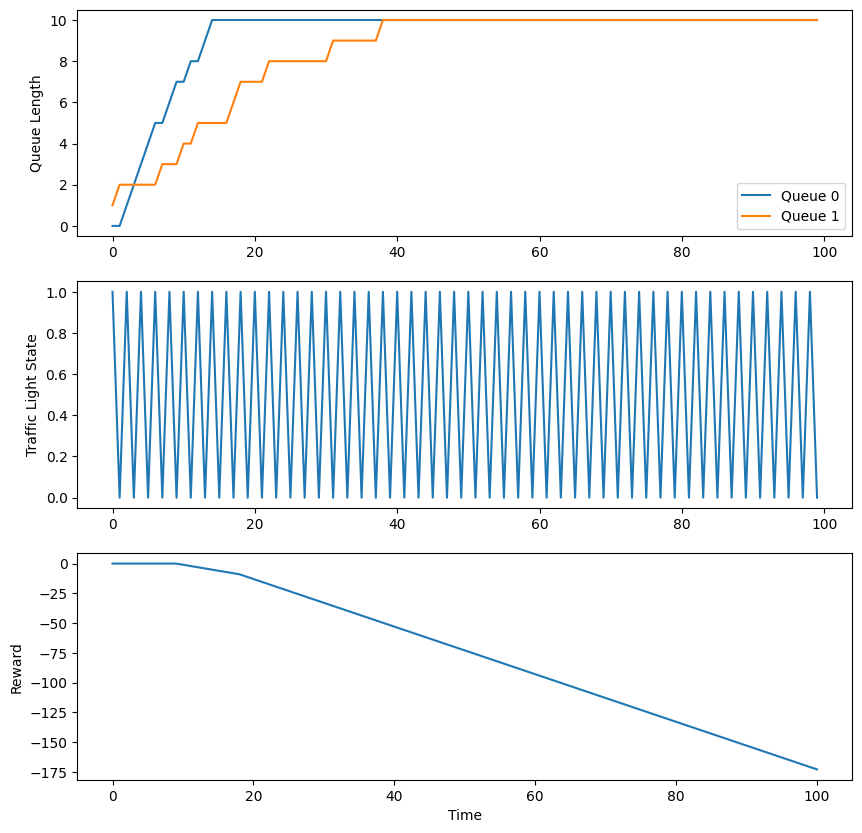

In [67]:
# now lets use the policy to actually do some control
# okay now lets run the policy and see how it goes!
# Lets do a rollout and visualize the length of each of the queues and the reward
# as a function of time
episode_length = 100
max_queue_size = 10
env = TrafficLightEnv(car_arrival_prob=NORTH_PROB, max_queue_size=max_queue_size)
state = env.reset()
states = np.zeros((episode_length, 3))
rewards = np.zeros(episode_length + 1)
    
for t in range(episode_length):
    arr_state = [state[0], state[1], 0 if state[2] == 'N' else 1]
    action = ['No-Op', 'Switch'][q_function.act(arr_state, epsilon_greedy, random_action=False)]
    new_state, reward = env.step(state, action)
    states[t, 0] = new_state[0]
    states[t, 1] = new_state[1]
    states[t, 2] = 1 if new_state[2] == 'E' else 0
    rewards[t + 1] = reward + rewards[t]
    state = new_state
    
# plot the queues on one plot and then the rewards on another
# in a grid
fig, ax = plt.subplots(3, 1, figsize=(10, 10))
ax[0].plot(states[:, :2])
ax[0].set_ylabel('Queue Length')
ax[0].legend(['Queue 0', 'Queue 1'])

# plot the tl states
ax[1].plot(states[:, 2])
ax[1].set_ylabel('Traffic Light State')

ax[2].plot(rewards)
ax[2].set_xlabel('Time')
ax[2].set_ylabel('Reward')
plt.show()

In [64]:
q_function.act([0, 10, 0], 0.9, random_action=False)


0